In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
# matplotlib parameters to ensure correctness of Chinese characters 
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif']=['Arial Unicode MS', 'SimHei'] # Chinese font
plt.rcParams['axes.unicode_minus']=False # correct minus sign

plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

In [4]:
np.random.seed(1901)
xx, yy = np.meshgrid(np.arange(100), np.arange(100)) #(100,100)
indices = np.random.choice(np.arange(1000000), 98, replace=False) #从给定的1维数组中随机采样的函数
mask = np.zeros(1000000).astype(bool)
mask[indices] = True #设置阳性
mask[33]=True
mask[277]=True
# fig, ax = plt.subplots(1,1, figsize=(10,10), dpi=150)
# ax.scatter(xx.flatten()[mask],yy.flatten()[mask],  s=40, color='k', marker='x' )
# ax.scatter(xx.flatten()[~mask],yy.flatten()[~mask],s=20, color='k', )
# ax.set_xlim(-1,100)
# ax.set_ylim(-1,100)
# %%
rvar = np.random.rand(mask.shape[0])
test_res = np.zeros_like(mask)
for i in range(mask.shape[0]):
    test_res[i] = rvar[i] >= 0.10 if mask[i] else rvar[i] >= 0.9999 # 被检测为阳性
test_res[144]=True
sum(mask)

100

In [5]:
def gen_marker(fname):
    person_path, attributes = svg2paths(fname)
    person_marker = parse_path(attributes[0]['d'])
    person_marker.vertices -= person_marker.vertices.mean(axis=0)
    person_marker = person_marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
    person_marker = person_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    return person_marker

person_marker = gen_marker('figures/person.svg')
patient_marker = gen_marker('figures/patient.svg')

In [46]:
class UpdateDist:
    def __init__(self, ax0, ax, ax1, patient_mask):
        self.success = 0

        self.ax0 = ax0
        xn, yn = 40, 10
        xx, yy = np.meshgrid(np.arange(xn), np.arange(yn))
        # indices = np.random.choice(np.arange(int(xn*yn)), int(xn*yn/100), replace=False)
        self.mask_plt = patient_mask[:int(xn*yn)]
        self.sc_patient = ax0.scatter(xx.flatten()[self.mask_plt],yy.flatten()[self.mask_plt],  s=2000, facecolor=[1,0,0,1], marker=patient_marker)
        self.sc_person  = ax0.scatter(xx.flatten()[~self.mask_plt],yy.flatten()[~self.mask_plt],s=2000, facecolor=[0,32./255,96./255,1], marker=person_marker)
        self.color = np.tile([0,32./255,96./255,1],(int(xn*yn),1))
        self.color[self.mask_plt,:] = [1,0,0,1]
        self.ax0.set_xlim(-1,xn)
        self.ax0.set_ylim(-1,yn)
        self.ax0.invert_yaxis()

        self.rects = ax.barh([1,2], [0,0], ) #条形图
        for rec, color in zip(self.rects, ( [228./255,131./255,18./255,1], [0,176./255,80./255,1] )):
            rec.set_color(color)
                 
        self.ax = ax
        self.ax.set_yticks([1,2])
        self.ax.set_yticklabels(["", ""])
        self.ax.set_xlabel("检测人数对数"+r'$log_{10}(x)$', fontsize=30)
        # self.ax.set_yticklabels(["检测阳性新冠患者","检测阳性健康人群", "检测阴性"], fontsize=20)
        #self.ax.text(-0.130, 0.17, "新冠患者", transform=self.ax.transAxes, fontsize=25, color='r', )
        #self.ax.text(-0.130, 0.27, "检测阳性", transform=self.ax.transAxes, fontsize=25, color=[228./255,131./255,18./255,1], )
        #self.ax.text(-0.130, 0.43, "健康人群", transform=self.ax.transAxes, fontsize=25, color=[0,32./255,96./255,1], )
        self.ax.text(-0.130, 0.21, "检测阳性", transform=self.ax.transAxes, fontsize=25, color=[228./255,131./255,18./255,1], )
        self.ax.text(-0.130, 0.47, "检测阴性", transform=self.ax.transAxes, fontsize=25, color=[0,176./255,80./255,1], )
        # self.ax.set_yticklabels(["True Positive","False Positive", "Negative"], fontsize=20)
        # self.ax.set_xlabel("Number of people", fontsize=20)

        # Set up plot parameters
        self.ax.set_ylim(0, 4)
        self.ax.set_xlim(0, 7)
        self.ax.spines['top'].set_visible(False)
        self.ax.spines['right'].set_visible(False)

        self.line, =ax1.plot([],[])
        self.ax1 = ax1
        self.ax1.set_xlim([0,7])
        self.ax1.set_ylim([0,0.05])
        self.ax1.set_ylabel("阳性的频率", fontsize=25) 
        self.ax1.set_xlabel("检测人数对数"+r'$log_{10}(x)$', fontsize=30)
        # self.ax1.set_xlabel('Number of people tested', fontsize=20)
        # self.ax1.set_ylabel('Test accuracy', fontsize=20)
        self.ax1.spines['top'].set_visible(False)
        self.ax1.spines['right'].set_visible(False)
        #self.ax1.axhline(0.0917, linestyle='--', color='black')#0.01*0.9/(0.01*0.9+0.99*0.09)=0.0917
        #self.ax1.axhline(0.0981, linestyle='--', color='black')#0.99*0.09+0.01*0.9=0.0981
        self.ax1.axhline(0.00019, linestyle='--', color='black')#0.9999*0.0001+0.0001*0.9
        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            self.success = 0
            for rect, h in zip(self.rects, [0,0]): 
                rect.set_width(h)
            self.line, = self.ax1.plot([], [], lw=5, color='r')
            return self.rects

        # Choose success based on exceed a threshold with a uniform pick
        # if np.random.rand(1,) < self.prob:
        #     self.success += 1
        # y = beta_pdf(self.x, self.success + 1, (i - self.success) + 1)
        # self.line.set_data(self.x, y)

        if i <= 100:
            n_inc = 4
            # update histogram
            #sick_n = (test_res*mask)[:n_inc*(i+1)].sum() #检测为阳性的新冠患者
            #healthy_n = (test_res*(~mask))[:n_inc*(i+1)].sum() #检测为阳性的健康人数
            negative = np.sum(~test_res[:n_inc*(i+1)]) #检测为阴性的人
            positive = np.sum(test_res[:n_inc*(i+1)]) #检测为阳性的人
            for rect, h in zip(self.rects, [math.log(positive+1,10),math.log(negative+1,10)]): 
                rect.set_width(h)
            #for rect in self.rects:
            #    height=rect.get_height()
            #    self.ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,'%d' % int(height),ha='center', va='bottom')
            # update curve
            xdata, ydata = self.line.get_data()
            if len(xdata) == 0:
                xdata = [0]
                ydata = [positive*1.0/(positive+negative)]
            else:
                xdata = np.append(xdata, math.log(n_inc*(i+1),10)) 
                ydata = np.append(ydata, positive*1.0/(positive+negative)) 
            self.line.set_data(xdata, ydata)
        else: 
            n_inc = 3000
            # update histogram
            #sick_n = (test_res*mask)[:401+n_inc*(i-99)].sum()
            #healthy_n = (test_res*(~mask))[:401+n_inc*(i-99)].sum()
            negative = np.sum(~test_res[:401+n_inc*(i-99)])
            positive = np.sum(test_res[:401+n_inc*(i-99)])
            for rect, h in zip(self.rects, [math.log(positive,10),math.log(negative,10)]): 
                rect.set_width(h)
            # update curve
            #self.ax1.set_ylim([0,0.003])
            xdata, ydata = self.line.get_data()
            xdata = np.append(xdata, math.log(401+n_inc*(i-99),10)) 
            ydata = np.append(ydata, positive*1.0/(positive+negative)) 
            self.line.set_data(xdata, ydata)
        # update scatter facecolor
        if i>=150:
            self.ax1.set_ylim([0,0.003])
        
        if i <= 100:
            n_inc = 4
            for j in range(n_inc):
                # idx = i-1
                idx = (i-1)*n_inc+j
                self.color[idx,:] = [228./255,131./255,18./255,1] if test_res[idx] else [0,176./255,80./255,1]
            self.sc_person.set_facecolor(self.color[~self.mask_plt,:])
            self.sc_patient.set_facecolor(self.color[self.mask_plt,:])
        return self.rects

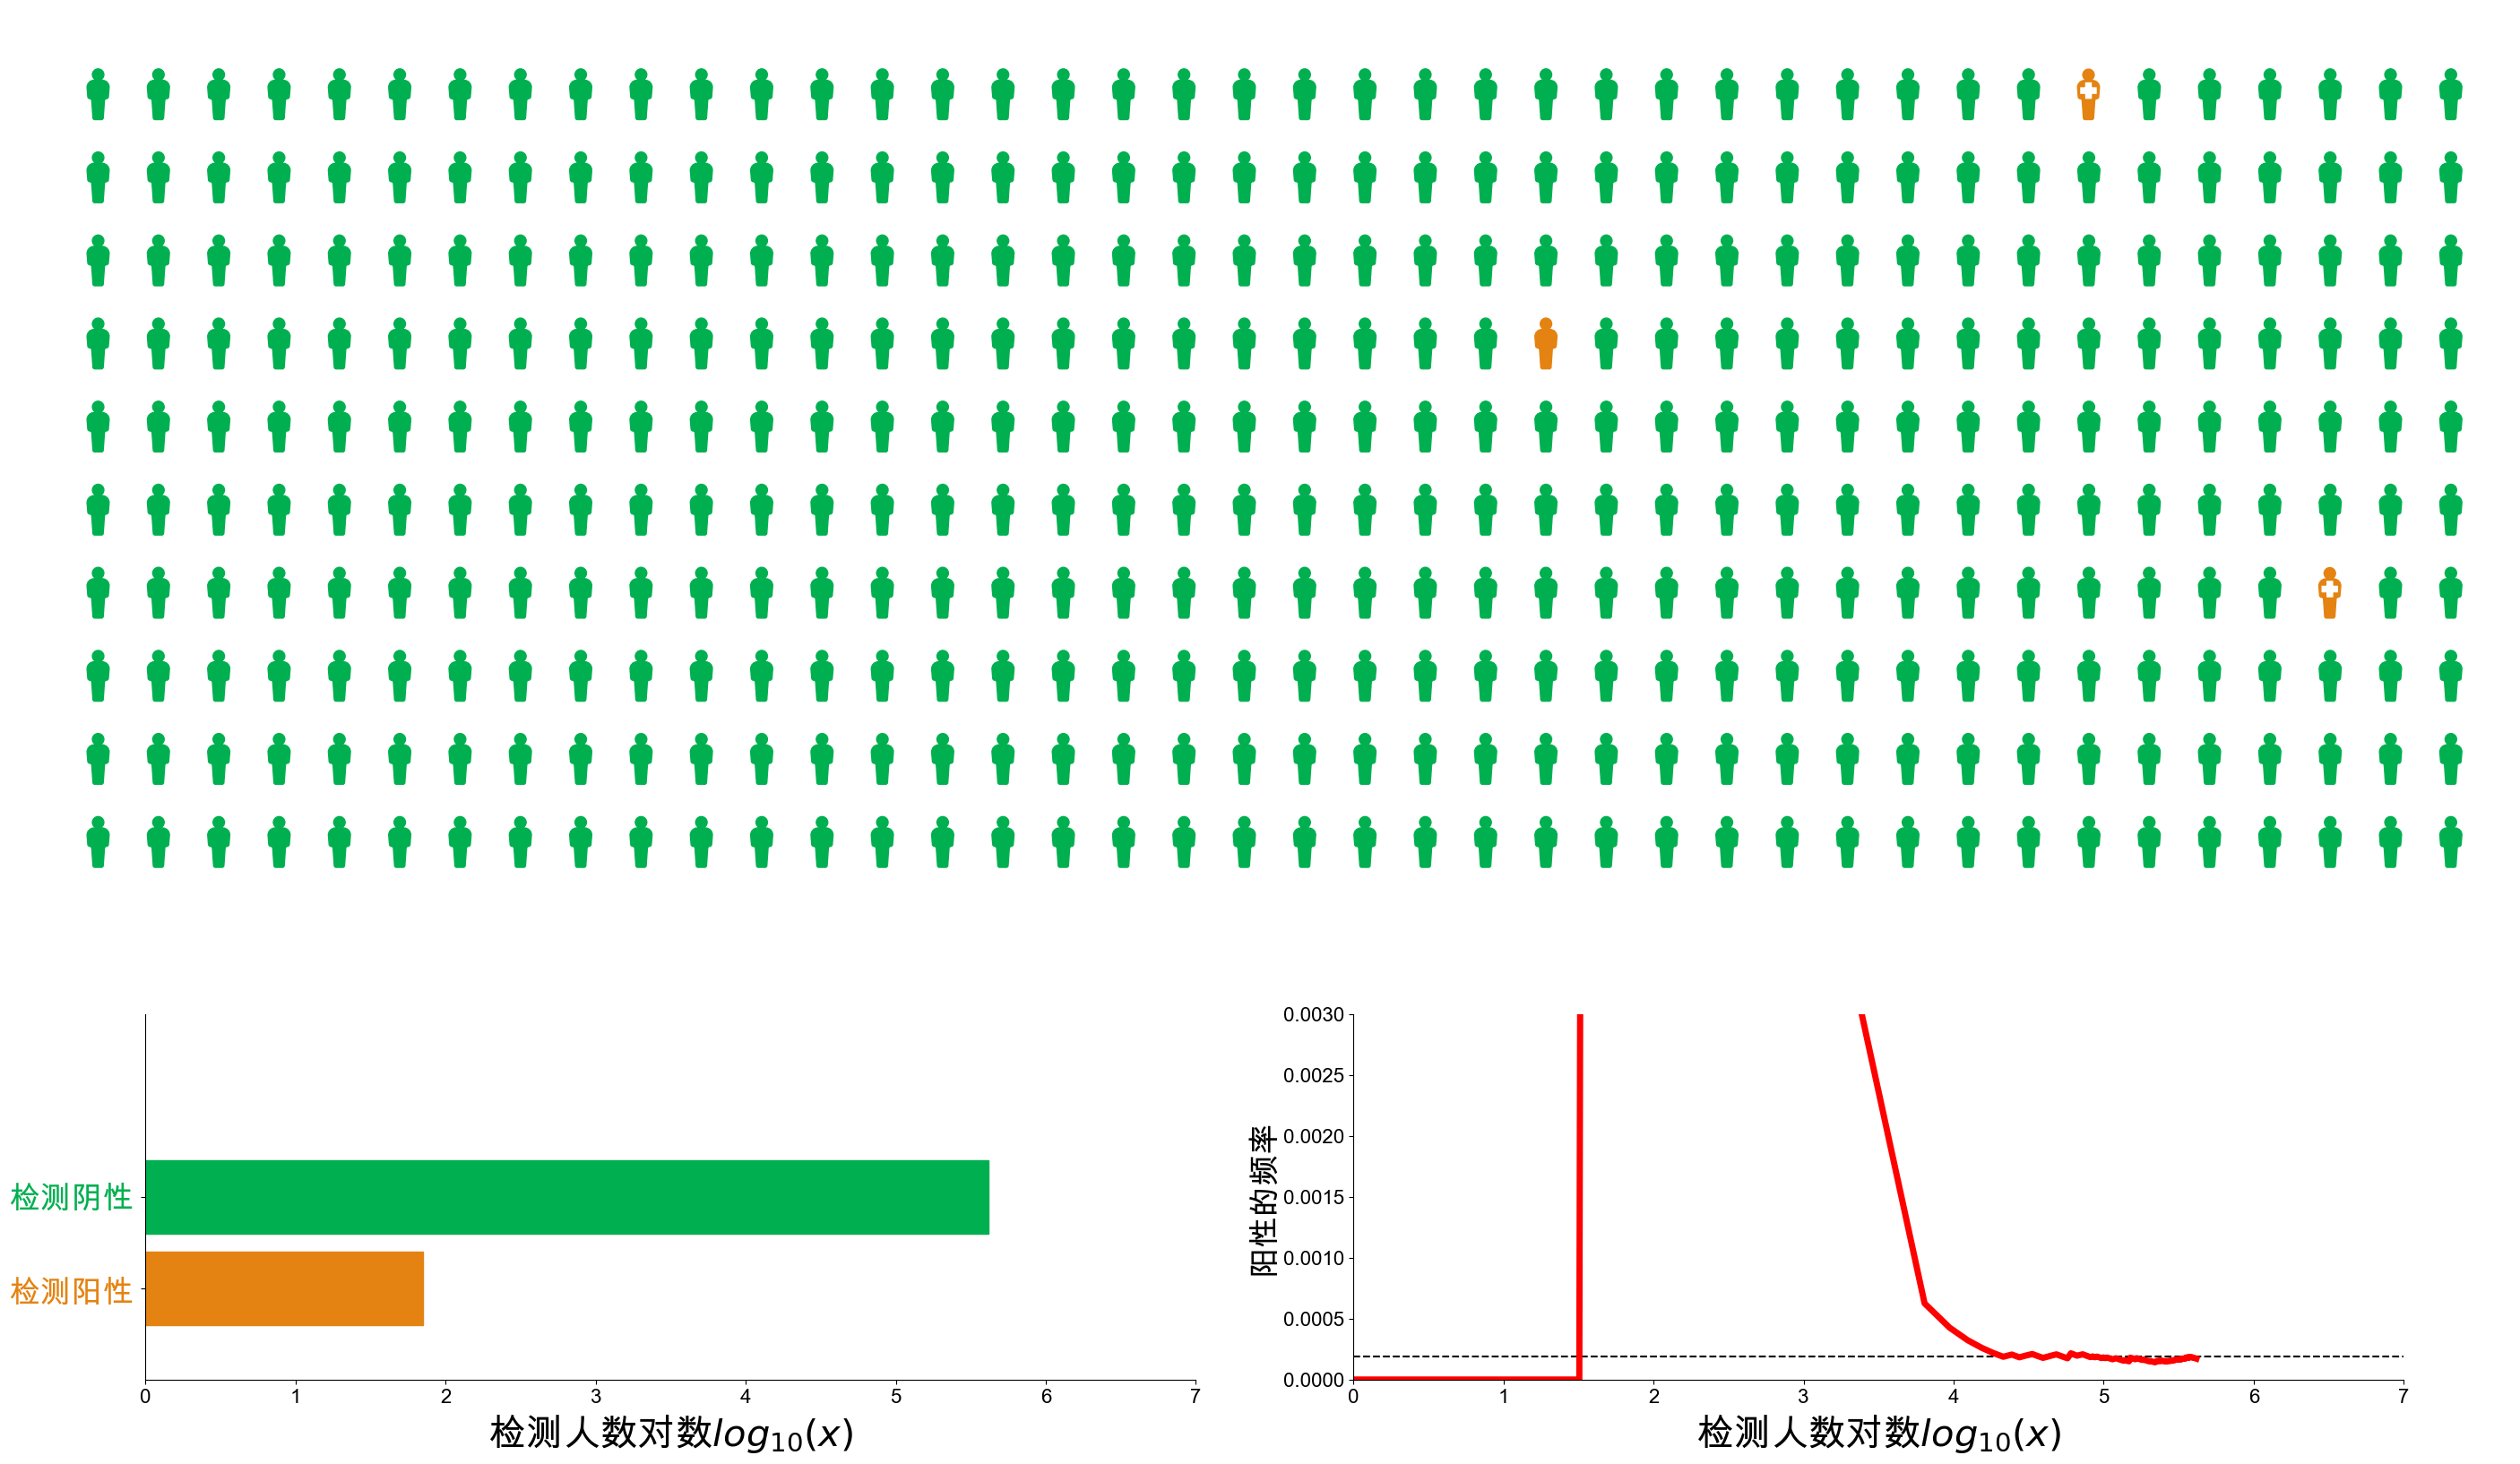

In [47]:
fig = plt.figure(figsize=(30,17),dpi=100)
spec1 = gridspec.GridSpec(ncols=1, nrows=1, left=0.04, right=0.96, top=0.98, bottom=0.38, figure=fig)
ax0 = fig.add_subplot(spec1[0])
ax0.axis('off')
spec2 = gridspec.GridSpec(ncols=2, nrows=1, left=0.08, right=0.92, top=0.32, bottom=0.08, wspace=0.15, figure=fig)
ax1 = fig.add_subplot(spec2[0])
ax2 = fig.add_subplot(spec2[1])
ud = UpdateDist(ax0, ax1, ax2, mask)
anim = FuncAnimation(fig, ud, frames=238, blit=True)
anim.save('test_movie3.mp4', fps=10, dpi=200, codec='libx264', bitrate=-1, extra_args=['-pix_fmt', 'yuv420p'])

In [36]:
import math
math.log(8,2)
math.log(1000000,2)

19.931568569324174

In [10]:
0.9999*0.0001+0.0001*0.9

0.00018999000000000002